In [26]:
import autograd.numpy as np
from scipy.integrate import solve_bvp, odeint
from matplotlib import pyplot as plt
from autograd import grad, elementwise_grad

In [27]:
C_m  =   1.0
# membrane capacitance, in uF/cm^2

g_Na = 120.0
# Sodium (Na) maximum conductances, in mS/cm^2

g_K  =  36.0
# Postassium (K) maximum conductances, in mS/cm^2

g_L  =   0.3
# Leak maximum conductances, in mS/cm^2

V_Na =  50.0
# Sodium (Na) Nernst reversal potentials, in mV

V_K  = -77.0
# Postassium (K) Nernst reversal potentials, in mV

V_L  = -54.387
# Leak Nernst reversal potentials, in mV

I = 35
# injected current

def alpha_n(V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 0.01*(V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

dalpha_n = elementwise_grad(alpha_n)

def beta_n(V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 0.125*np.exp(-(V+65) / 80.0)

dbeta_n = elementwise_grad(beta_n)

def alpha_m(V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))

dalpha_m = elementwise_grad(alpha_m)

def beta_m(V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 4.0*np.exp(-(V+65.0) / 18.0)

dbeta_m = elementwise_grad(beta_m)

def alpha_h(V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 0.07*np.exp(-(V+65.0) / 20.0)

dalpha_h = elementwise_grad(alpha_h)

def beta_h(V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))

dbeta_h = elementwise_grad(beta_h)

In [28]:
class HodgkinHuxley():
    """Full Hodgkin-Huxley Model implemented in Python"""

    C_m  =   1.0
    """membrane capacitance, in uF/cm^2"""

    g_Na = 120.0
    """Sodium (Na) maximum conductances, in mS/cm^2"""

    g_K  =  36.0
    """Postassium (K) maximum conductances, in mS/cm^2"""

    g_L  =   0.3
    """Leak maximum conductances, in mS/cm^2"""

    E_Na =  50.0
    """Sodium (Na) Nernst reversal potentials, in mV"""

    E_K  = -77.0
    """Postassium (K) Nernst reversal potentials, in mV"""

    E_L  = -54.387
    """Leak Nernst reversal potentials, in mV"""

    t_step = 0.01
    t = np.arange(0.0, 100.0, t_step)
    """ The time to integrate over """

    def alpha_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 4.0*np.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.07*np.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))

    def alpha_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.125*np.exp(-(V+65) / 80.0)

    def I_Na(self, V, m, h):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)

        |  :param V:
        |  :param m:
        |  :param h:
        |  :return:
        """
        return self.g_Na * m**3 * h * (V - self.E_Na)

    def I_K(self, V, n):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_K  * n**4 * (V - self.E_K)
    #  Leak
    def I_L(self, V):
        """
        Membrane current (in uA/cm^2)
        Leak

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_L * (V - self.E_L)

    def I_inj(self, t):
        """
        External Current

        |  :param t: time
        |  :return: step up to 10 uA/cm^2 at t>100
        |           step down to 0 uA/cm^2 at t>200
        |           step up to 35 uA/cm^2 at t>300
        |           step down to 0 uA/cm^2 at t>400
        """
        return I*(t > 50)

    @staticmethod
    def dALLdt(X, t, self):
        """
        Integrate

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V, m, h, n = X

        dVdt = (self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return dVdt, dmdt, dhdt, dndt

    def Main(self):
        """
        Main demo for the Hodgkin Huxley neuron model
        """

        X = odeint(self.dALLdt, [-65, 0.05, 0.6, 0.32], self.t, args=(self,))
        V = X[:,0]
        m = X[:,1]
        h = X[:,2]
        n = X[:,3]
        ina = self.I_Na(V, m, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)

        plt.figure(figsize=(8,8))

        plt.subplot(4,1,1)
        plt.title('Hodgkin-Huxley Neuron')
        plt.plot(self.t, V, 'k')
        plt.ylabel('V (mV)')

        plt.subplot(4,1,2)
        plt.plot(self.t, ina, 'c', label='$I_{Na}$')
        plt.plot(self.t, ik, 'y', label='$I_{K}$')
        plt.plot(self.t, il, 'm', label='$I_{L}$')
        plt.ylabel('Current')
        plt.legend()

        plt.subplot(4,1,3)
        plt.plot(self.t, m, 'r', label='m')
        plt.plot(self.t, h, 'g', label='h')
        plt.plot(self.t, n, 'b', label='n')
        plt.ylabel('Gating Value')
        plt.legend()

        plt.subplot(4,1,4)
        i_inj_values = [self.I_inj(t) for t in self.t]
        plt.plot(self.t, i_inj_values, 'k')
        plt.xlabel('t (ms)')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        plt.ylim(-1, 40)

        plt.show()


    def get_initial_conditions(self, plot=False, index=99.99):
        """
        Main demo for our altered Hodgkin Huxley neuron model
        """
        # TODO: new initial conditions
        X = odeint(self.dALLdt, [-65, 0.05, 0.6, 0.32], self.t, args=(self,))
        
        V = X[:,0]
        m = X[:,1]
        h = X[:,2]
        n = X[:,3]
        ina = self.I_Na(V, m, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)
        
        y = [
            V[int(index/self.t_step)],
            n[int(index/self.t_step)],
            m[int(index/self.t_step)],
            h[int(index/self.t_step)]
        ]

        if plot:
            plt.figure(figsize=(15,10))

            plt.subplot(4,1,1)
            plt.title('Getting Initial Conditions for Neuron Model')
            plt.plot(self.t, V, 'k')
            plt.scatter(self.t[int(index/self.t_step)], V[int(index/self.t_step)])
            plt.ylabel('V (mV)')

            plt.subplot(4,1,2)
            plt.plot(self.t, ina, 'c', label='$I_{Na}$')
            plt.plot(self.t, ik, 'y', label='$I_{K}$')
            plt.plot(self.t, il, 'm', label='$I_{L}$')
            plt.ylabel('Current')
            plt.legend()

            plt.subplot(4,1,3)
            plt.plot(self.t, h, 'g', label='h')
            plt.plot(self.t, m, 'y', label='m')
            plt.plot(self.t, n, 'b', label='n')
            plt.ylabel('Gating Value')
            plt.legend()

            plt.subplot(4,1,4)
            i_inj_values = [self.I_inj(t) for t in self.t]
            plt.plot(self.t, i_inj_values, 'k')
            plt.xlabel('t (ms)')
            plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
            plt.ylim(-1, 40)

            plt.show()
        
        return y

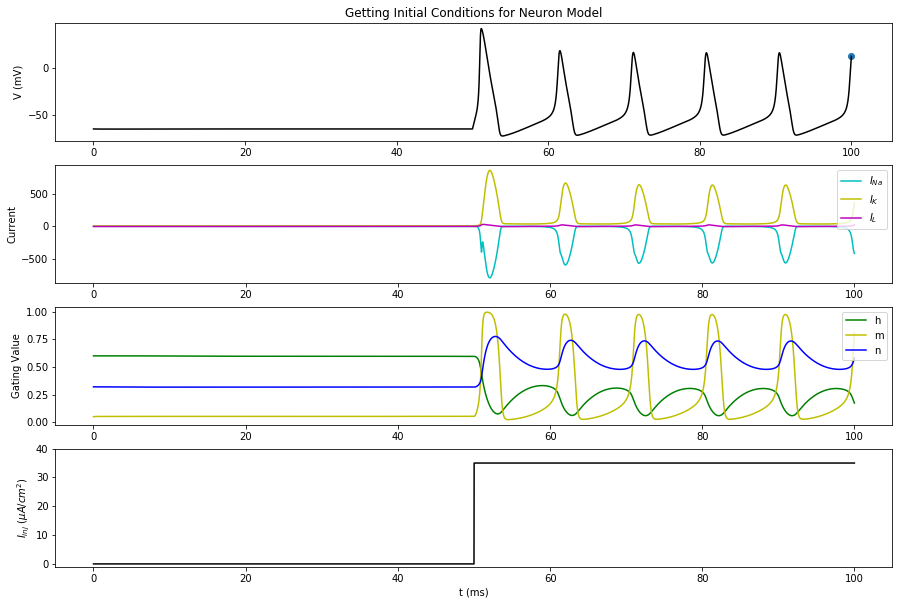

[12.479838787376119,
 0.5803302354579435,
 0.8133326281447187,
 0.17351686767122473]

In [29]:
runner = HodgkinHuxley()
runner.get_initial_conditions(plot=True)

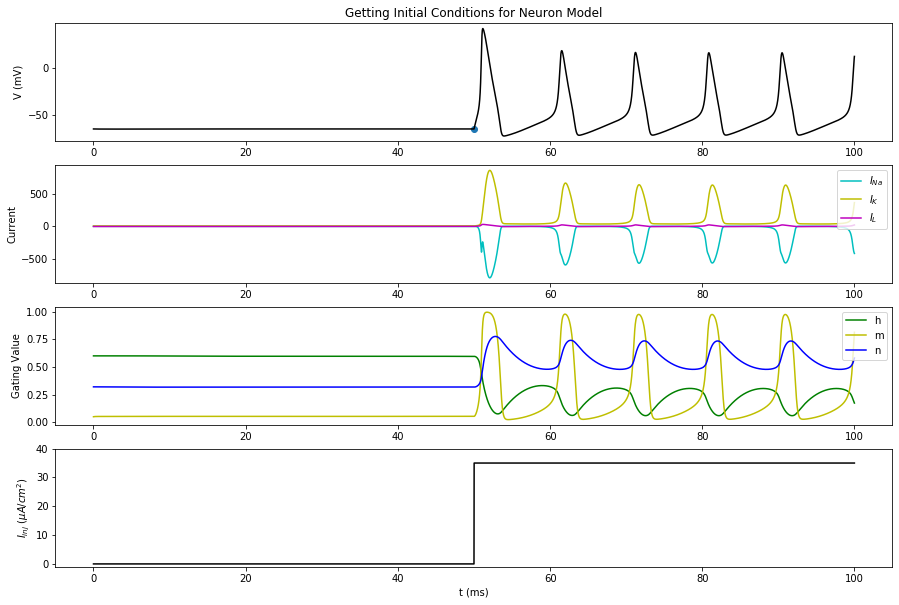

tf guess: [10]
[6.56664868]


/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_bvp.py:487: RuntimeWarning: invalid value encountered in less
  if (np.all(np.abs(col_res) < tol_r * (1 + np.abs(f_middle))) and


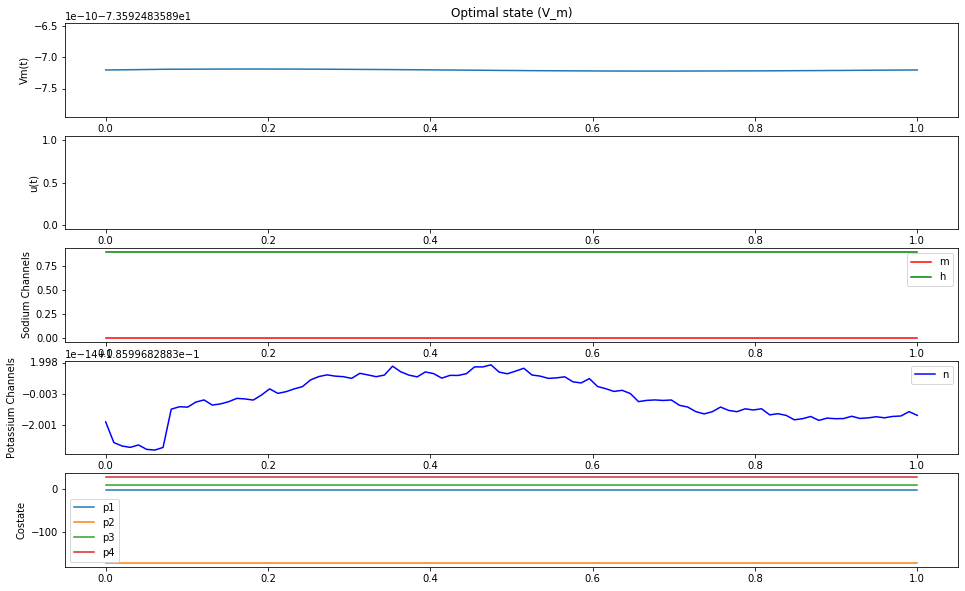

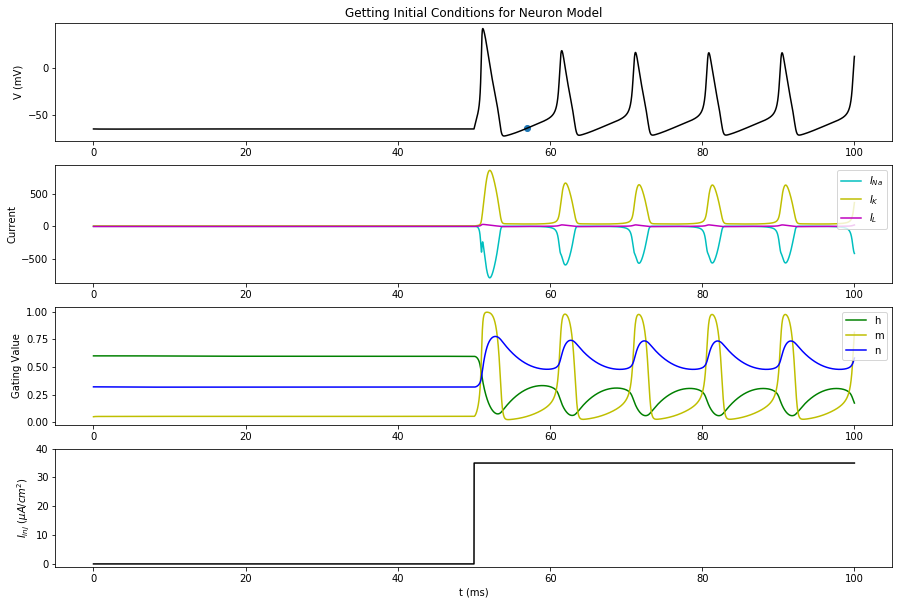

tf guess: [10]


/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


[6.68810228e-08]


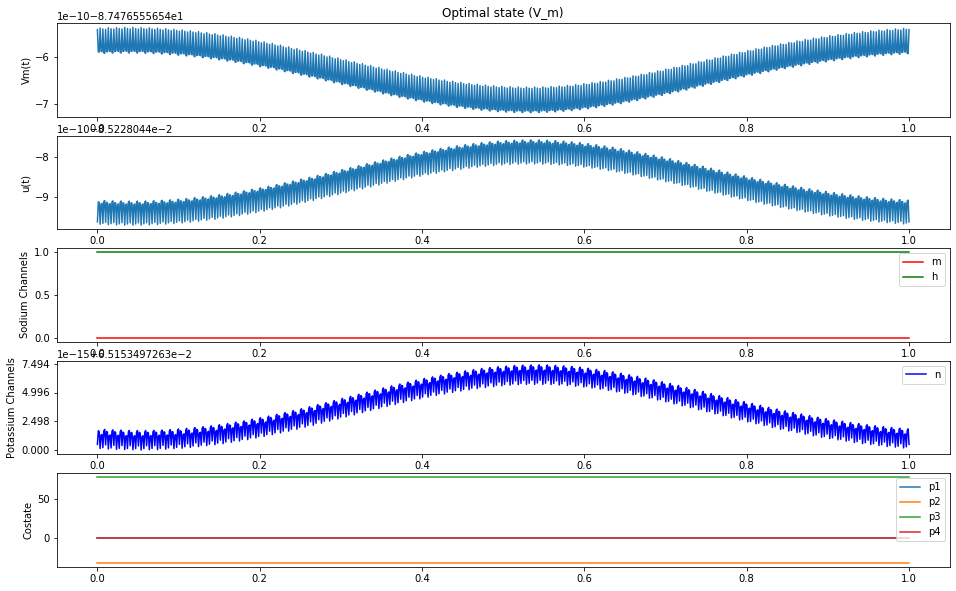

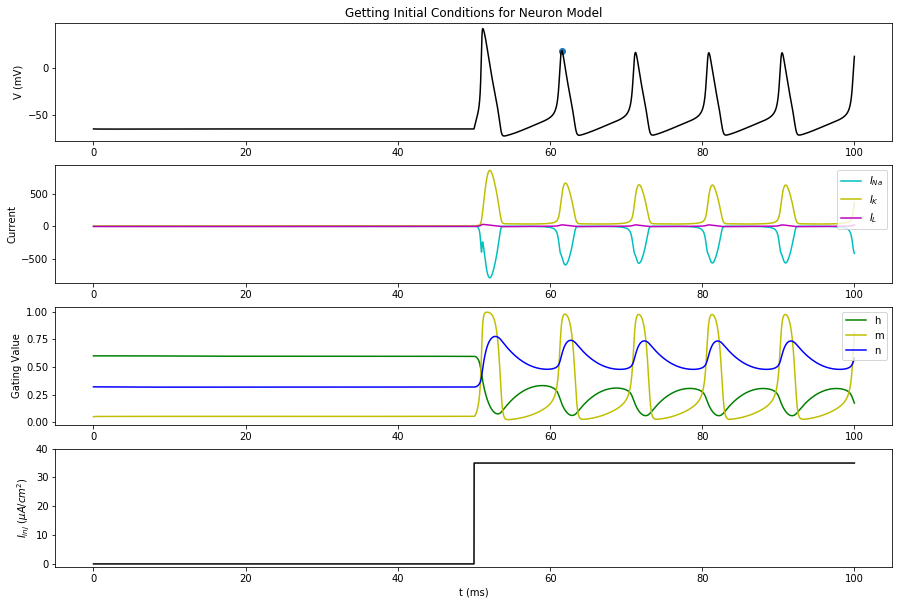

tf guess: [10]
[-6.82171881e-18]


/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


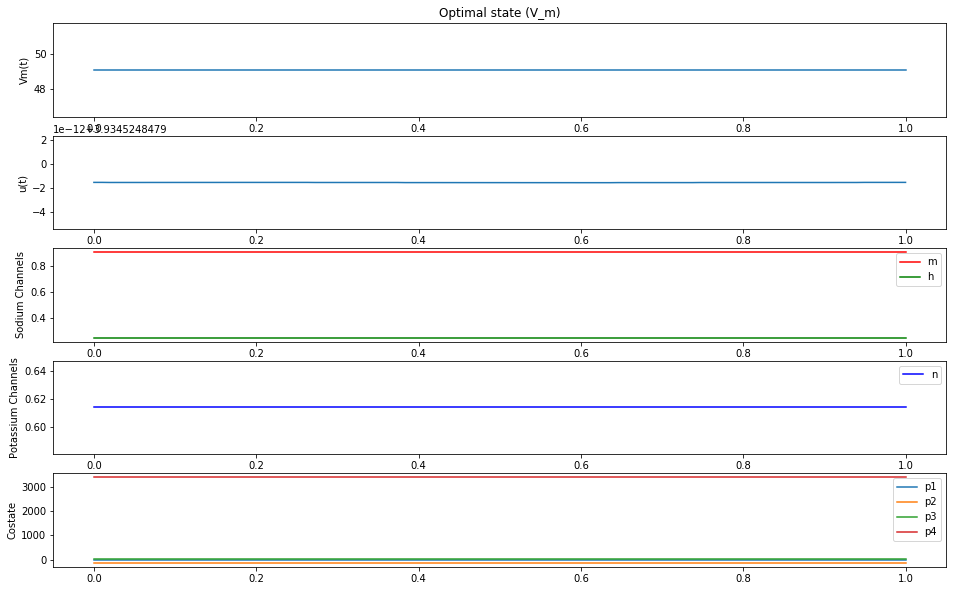

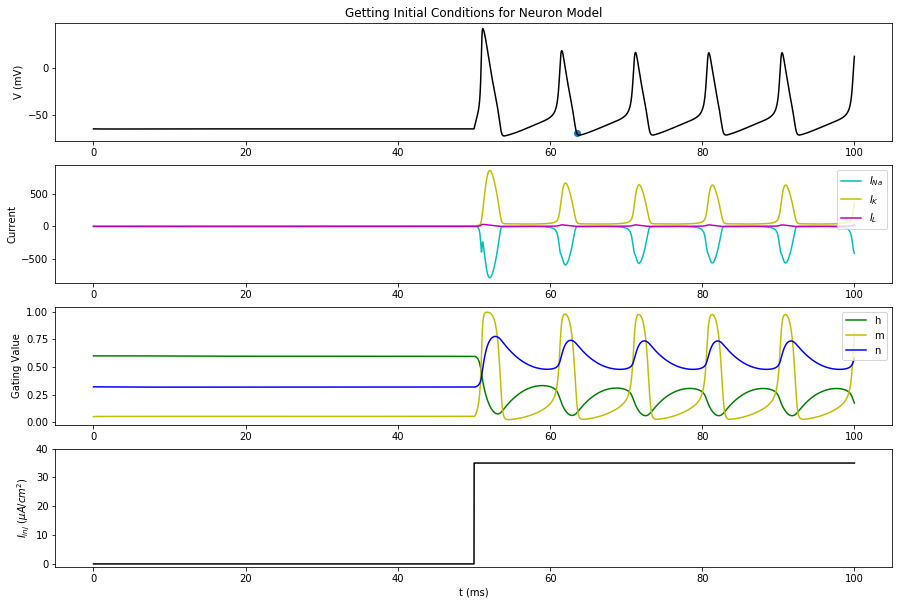

tf guess: [10]


/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


[11.98293124]


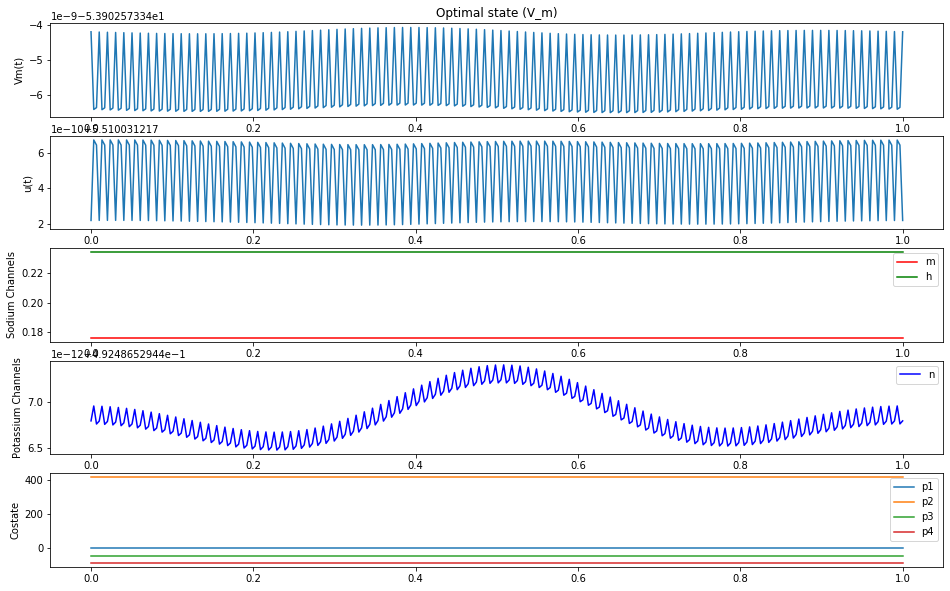

In [45]:
def f(t, y, tf):
    """
    outputs: [*(d state / dt), *(d costate / dt)]
    """
    # unpack values from state, costate
    Vm, n, m, h, p1, p2, p3, p4 = y
    
    # state evolution eqs
    u = np.log(p1 * g_Na * m**3 * h * (Vm - V_Na)) - np.log(2 * C_m)
    a = lambda u: np.exp(-u) * (1 + u)
#     au = (u + 1) * (2 * C_m) / (p1 * g_Na * m * (Vm - V_Na))
    au = a(u)
    dVm = (I - g_K * n**4 * (Vm - V_K) - g_L * (Vm - V_L) - g_Na * m**3 * h * au * (Vm - V_Na)) / C_m
    dn = alpha_n(Vm) * (1 - n) - beta_n(Vm) * n
    dm = alpha_m(Vm) * (1 - m) - beta_m(Vm) * m
    dh = alpha_h(Vm) * (1 - h) - beta_h(Vm) * h
    
    # costate evolution eqs
    pVm = p1 * (-g_K * n**4 - g_L - g_Na * m**3 * h * au)/C_m \
        + p2 * (dalpha_n(Vm) * (1 - n) - dbeta_n(Vm) * n)\
        + p3 * (dalpha_m(Vm) * (1 - m) - dbeta_m(Vm) * m) \
        + p4 * (dalpha_h(Vm) * (1 - h) - dbeta_h(Vm) * h)
    pn = p1 * (-4 * g_K * (n**3) * (Vm - V_K)) / C_m - p2 * (alpha_n(Vm) + beta_n(Vm))
    pm = p1 * (-3 * g_Na * (m**2) * h * (Vm - V_Na)) / C_m - p3 * (alpha_m(Vm) + beta_m(Vm))
    ph = p1 * (-g_Na * (m**3) * (Vm - V_Na)) / C_m - p4 * (alpha_h(Vm) + beta_h(Vm))
     
    return tf[0] * np.array([dVm, dn, dm, dh, pVm, pn, dm, ph])

def bc(ya, yb, tf):
    Vm, n, m, h, p1, p2, p3, p4 = yb
    
    # state evolution eqs
    u = np.log(p1 * g_Na * m**3 * h * (Vm - V_Na)) - np.log(2 * C_m)
    a = lambda u: np.exp(-u) * (1 + u)
#     au = (u + 1) * (2 * C_m) / (p1 * g_Na * m * (Vm - V_Na))
    au = a(u)
    dVm = (I - g_K * n**4 * (Vm - V_K) - g_L * (Vm - V_L) - g_Na * m**3 * h * au * (Vm - V_Na)) / C_m
    dn = alpha_n(Vm) * (1 - n) - beta_n(Vm) * n
    dm = alpha_m(Vm) * (1 - m) - beta_m(Vm) * m
    dh = alpha_h(Vm) * (1 - h) - beta_h(Vm) * h
    
    return np.array([
        ya[0] - yb[0],
        ya[1] - yb[1],
        ya[2] - yb[2],
        ya[3] - yb[3],
        ya[4] - yb[4],
        ya[5] - yb[5],
        ya[6] - yb[6],
        ya[7] - yb[7],
        p1 * dVm + p2 * dn + p3 * dm + p4 * dh - u**2 - (20*(tf[0] - T))
    ])

n_dims, n_points = 10, 100
t = np.linspace(0, 1, n_points)


for index in (50, 57, 61.5, 63.5):
    runner = HodgkinHuxley()
    y = runner.get_initial_conditions(plot=True, index=index)
    y_guess = np.hstack((
        y,
        -1*np.ones(4)
    ))
    y_guess = np.vstack(
        [y_guess] * n_points
    ).T

    tf_guess = [10]
    T = 12

    # for tf_guess in ([1], [10], [12.5], [100]):
    print(f"tf guess: {tf_guess}")
    sol = solve_bvp(f, bc, t, y_guess, tf_guess)
    print(sol.p)

    # unpack values from state, costate
    Vm, n, m, h, p1, p2, p3, p4 = sol.y
    costates = (p1, p2, p3, p4)

    # state evolution eqs
    u = np.log(p1 * g_Na * m * (Vm - V_Na)) - np.log(2 * C_m)

    # plot results
    plt.figure(figsize=(16,10))
    plt.subplot(511)
    plt.plot(sol.x, Vm)
    plt.xlabel("t")
    plt.ylabel("Vm(t)")
    plt.title("Optimal state (V_m)")

    plt.subplot(512)
    plt.plot(sol.x, u)
    plt.xlabel("t")
    plt.ylabel("u(t)")

    plt.subplot(513)
    plt.plot(sol.x, m, 'r', label='m')
    plt.plot(sol.x, h, 'g', label='h')
    plt.ylabel('Sodium Channels')
    plt.legend()

    plt.subplot(514)
    plt.plot(sol.x, n, 'b', label='n')
    plt.ylabel('Potassium Channels')
    plt.legend()

    plt.subplot(515)
    for i, pi in enumerate(costates):
        plt.plot(sol.x, pi, label=f"p{i+1}")
    plt.ylabel('Costate')
    plt.legend()

    plt.show()

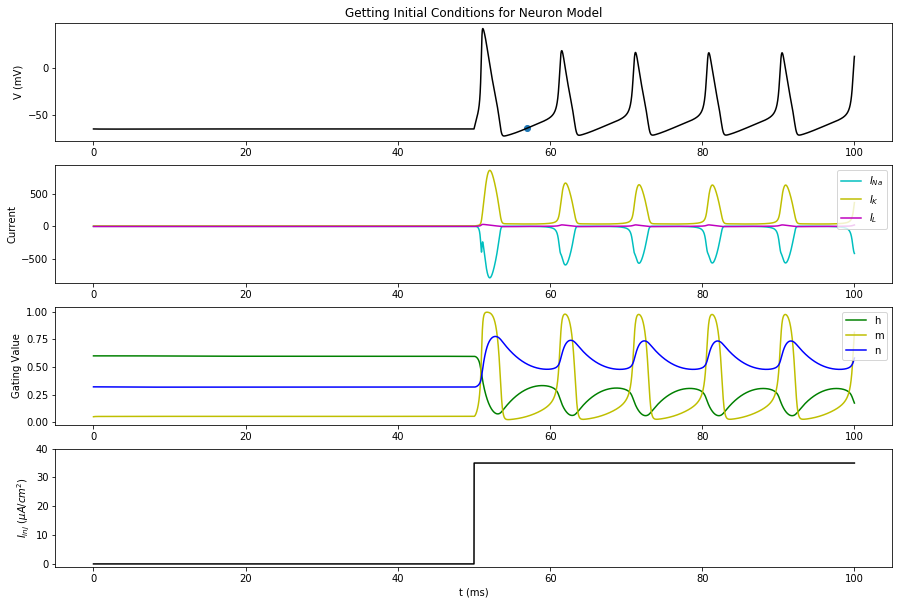

tf guess: [10]


/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


[10.32620715]


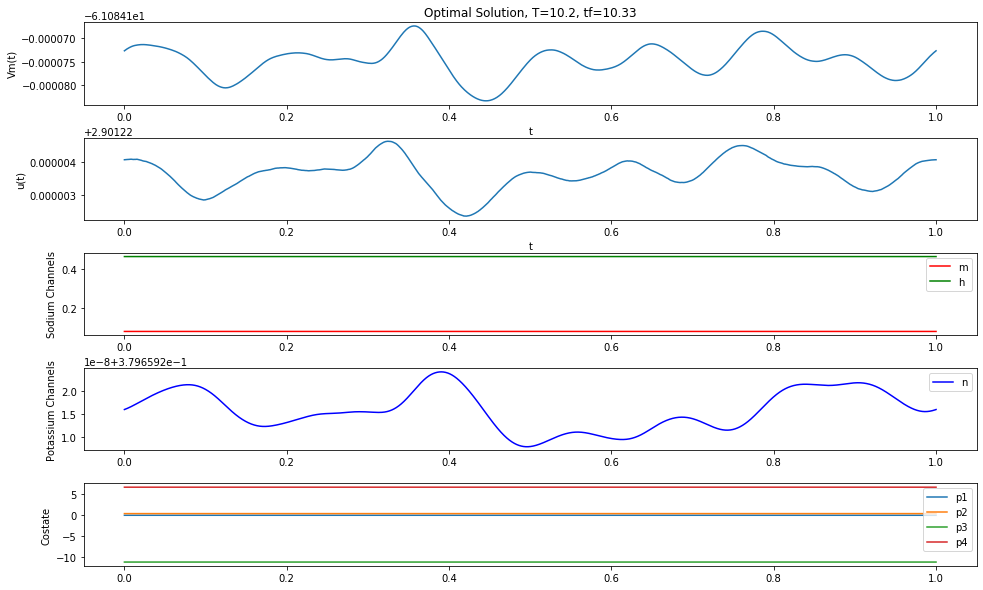

In [56]:
def f(t, y, tf):
    """
    outputs: [*(d state / dt), *(d costate / dt)]
    """
    # unpack values from state, costate
    Vm, n, m, h, p1, p2, p3, p4 = y
    
    # state evolution eqs
    u = np.log(p1 * g_Na * m**3 * h * (Vm - V_Na)) - np.log(2 * C_m)
    a = lambda u: np.exp(-u) * (1 + u)
#     au = (u + 1) * (2 * C_m) / (p1 * g_Na * m * (Vm - V_Na))
    au = a(u)
    dVm = (I - g_K * n**4 * (Vm - V_K) - g_L * (Vm - V_L) - g_Na * m**3 * h * au * (Vm - V_Na)) / C_m
    dn = alpha_n(Vm) * (1 - n) - beta_n(Vm) * n
    dm = alpha_m(Vm) * (1 - m) - beta_m(Vm) * m
    dh = alpha_h(Vm) * (1 - h) - beta_h(Vm) * h
    
    # costate evolution eqs
    pVm = p1 * (-g_K * n**4 - g_L - g_Na * m**3 * h * au)/C_m \
        + p2 * (dalpha_n(Vm) * (1 - n) - dbeta_n(Vm) * n)\
        + p3 * (dalpha_m(Vm) * (1 - m) - dbeta_m(Vm) * m) \
        + p4 * (dalpha_h(Vm) * (1 - h) - dbeta_h(Vm) * h)
    pn = p1 * (-4 * g_K * (n**3) * (Vm - V_K)) / C_m - p2 * (alpha_n(Vm) + beta_n(Vm))
    pm = p1 * (-3 * g_Na * (m**2) * h * (Vm - V_Na)) / C_m - p3 * (alpha_m(Vm) + beta_m(Vm))
    ph = p1 * (-g_Na * (m**3) * (Vm - V_Na)) / C_m - p4 * (alpha_h(Vm) + beta_h(Vm))
     
    return tf[0] * np.array([dVm, dn, dm, dh, pVm, pn, dm, ph])

def bc(ya, yb, tf):
    Vm, n, m, h, p1, p2, p3, p4 = yb
    
    # state evolution eqs
    u = np.log(p1 * g_Na * m**3 * h * (Vm - V_Na)) - np.log(2 * C_m)
    a = lambda u: np.exp(-u) * (1 + u)
#     au = (u + 1) * (2 * C_m) / (p1 * g_Na * m * (Vm - V_Na))
    au = a(u)
    dVm = (I - g_K * n**4 * (Vm - V_K) - g_L * (Vm - V_L) - g_Na * m**3 * h * au * (Vm - V_Na)) / C_m
    dn = alpha_n(Vm) * (1 - n) - beta_n(Vm) * n
    dm = alpha_m(Vm) * (1 - m) - beta_m(Vm) * m
    dh = alpha_h(Vm) * (1 - h) - beta_h(Vm) * h
    
    return np.array([
        ya[0] - yb[0],
        ya[1] - yb[1],
        ya[2] - yb[2],
        ya[3] - yb[3],
        ya[4] - yb[4],
        ya[5] - yb[5],
        ya[6] - yb[6],
        ya[7] - yb[7],
        p1 * dVm + p2 * dn + p3 * dm + p4 * dh - u**2 - (20*(tf[0] - T)**3)
    ])

n_dims, n_points = 10, 5000
t = np.linspace(0, 1, n_points)


index = 57
runner = HodgkinHuxley()
y = runner.get_initial_conditions(plot=True, index=index)
y_guess = np.hstack((
    y,
    -1*np.ones(4)
))
y_guess = np.vstack(
    [y_guess] * n_points
).T

tf_guess = [10]
T = 10.2

# for tf_guess in ([1], [10], [12.5], [100]):
print(f"tf guess: {tf_guess}")
sol = solve_bvp(f, bc, t, y_guess, tf_guess)
print(sol.p)

# unpack values from state, costate
Vm, n, m, h, p1, p2, p3, p4 = sol.y
costates = (p1, p2, p3, p4)

# state evolution eqs
u = np.log(p1 * g_Na * m * (Vm - V_Na)) - np.log(2 * C_m)

# plot results
plt.figure(figsize=(16,10))
plt.subplot(511)
plt.plot(sol.x, Vm)
plt.xlabel("t")
plt.ylabel("Vm(t)")
plt.title(f"Optimal Solution, T={T}, tf={round(sol.p[0], 2)}")

plt.subplot(512)
plt.plot(sol.x, u)
plt.xlabel("t")
plt.ylabel("u(t)")

plt.subplot(513)
plt.plot(sol.x, m, 'r', label='m')
plt.plot(sol.x, h, 'g', label='h')
plt.ylabel('Sodium Channels')
plt.legend()

plt.subplot(514)
plt.plot(sol.x, n, 'b', label='n')
plt.ylabel('Potassium Channels')
plt.legend()

plt.subplot(515)
for i, pi in enumerate(costates):
    plt.plot(sol.x, pi, label=f"p{i+1}")
plt.ylabel('Costate')
plt.legend()

plt.subplots_adjust(hspace=0.4)
plt.savefig('HH_model_hamiltonian_constraint', dpi=300)
plt.show()

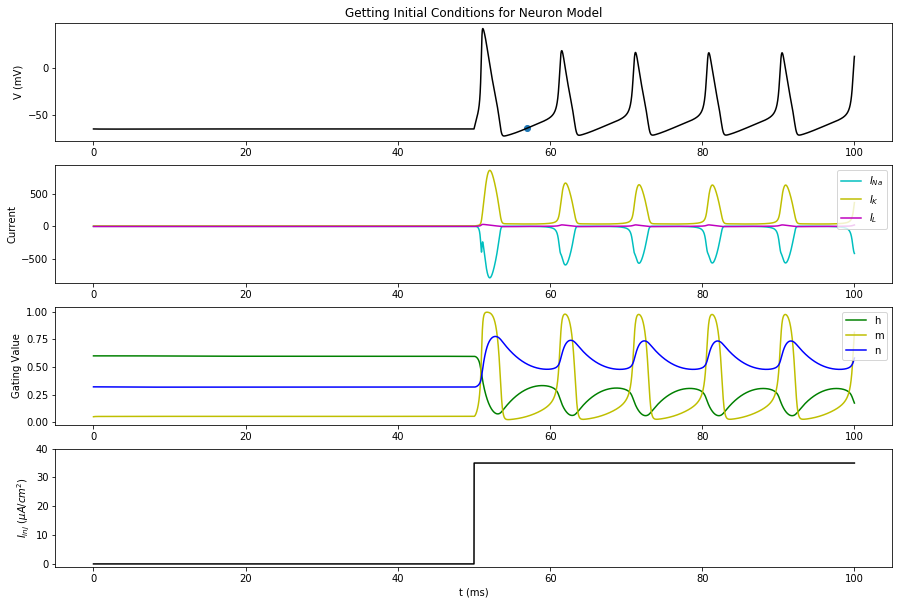

/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_bvp.py:1103: RuntimeWarning: invalid value encountered in greater
  insert_1, = np.nonzero((rms_res > tol) & (rms_res < 100 * tol))
/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_bvp.py:1103: RuntimeWarning: invalid value encountered in less
  insert_1, = np.nonzero((rms_res > tol) & (rms_res < 100 * tol))
/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_bvp.py:1104: RuntimeWarning: invalid value encountered in greater_equal
  insert_2, = np.nonzero(rms_res >= 100 * tol)


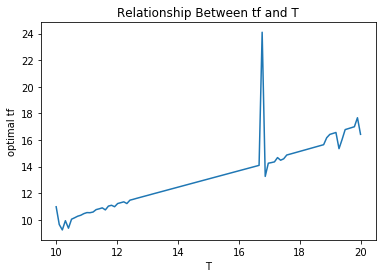

In [57]:
def f(t, y, tf):
    """
    outputs: [*(d state / dt), *(d costate / dt)]
    """
    # unpack values from state, costate
    Vm, n, m, h, p1, p2, p3, p4 = y
    
    # state evolution eqs
    u = np.log(p1 * g_Na * m**3 * h * (Vm - V_Na)) - np.log(2 * C_m)
    a = lambda u: np.exp(-u) * (1 + u)
#     au = (u + 1) * (2 * C_m) / (p1 * g_Na * m * (Vm - V_Na))
    au = a(u)
    dVm = (I - g_K * n**4 * (Vm - V_K) - g_L * (Vm - V_L) - g_Na * m**3 * h * au * (Vm - V_Na)) / C_m
    dn = alpha_n(Vm) * (1 - n) - beta_n(Vm) * n
    dm = alpha_m(Vm) * (1 - m) - beta_m(Vm) * m
    dh = alpha_h(Vm) * (1 - h) - beta_h(Vm) * h
    
    # costate evolution eqs
    pVm = p1 * (-g_K * n**4 - g_L - g_Na * m**3 * h * au)/C_m \
        + p2 * (dalpha_n(Vm) * (1 - n) - dbeta_n(Vm) * n)\
        + p3 * (dalpha_m(Vm) * (1 - m) - dbeta_m(Vm) * m) \
        + p4 * (dalpha_h(Vm) * (1 - h) - dbeta_h(Vm) * h)
    pn = p1 * (-4 * g_K * (n**3) * (Vm - V_K)) / C_m - p2 * (alpha_n(Vm) + beta_n(Vm))
    pm = p1 * (-3 * g_Na * (m**2) * h * (Vm - V_Na)) / C_m - p3 * (alpha_m(Vm) + beta_m(Vm))
    ph = p1 * (-g_Na * (m**3) * (Vm - V_Na)) / C_m - p4 * (alpha_h(Vm) + beta_h(Vm))
     
    return tf[0] * np.array([dVm, dn, dm, dh, pVm, pn, dm, ph])

def bc(ya, yb, tf):
    Vm, n, m, h, p1, p2, p3, p4 = yb
    
    # state evolution eqs
    u = np.log(p1 * g_Na * m**3 * h * (Vm - V_Na)) - np.log(2 * C_m)
    a = lambda u: np.exp(-u) * (1 + u)
#     au = (u + 1) * (2 * C_m) / (p1 * g_Na * m * (Vm - V_Na))
    au = a(u)
    dVm = (I - g_K * n**4 * (Vm - V_K) - g_L * (Vm - V_L) - g_Na * m**3 * h * au * (Vm - V_Na)) / C_m
    dn = alpha_n(Vm) * (1 - n) - beta_n(Vm) * n
    dm = alpha_m(Vm) * (1 - m) - beta_m(Vm) * m
    dh = alpha_h(Vm) * (1 - h) - beta_h(Vm) * h
    
    return np.array([
        ya[0] - yb[0],
        ya[1] - yb[1],
        ya[2] - yb[2],
        ya[3] - yb[3],
        ya[4] - yb[4],
        ya[5] - yb[5],
        ya[6] - yb[6],
        ya[7] - yb[7],
        p1 * dVm + p2 * dn + p3 * dm + p4 * dh - u**2 - (20*(tf[0] - T)**3)
    ])

n_dims, n_points = 10, 5000
t = np.linspace(0, 1, n_points)


index = 57
runner = HodgkinHuxley()
y = runner.get_initial_conditions(plot=True, index=index)
y_guess = np.hstack((
    y,
    -1*np.ones(4)
))
y_guess = np.vstack(
    [y_guess] * n_points
).T

Ts = np.linspace(10, 20, 100)
tf_opts = []
for T in Ts:
    tf_guess = [10]

    sol = solve_bvp(f, bc, t, y_guess, tf_guess)
    tf_opts.append(sol.p[0])
    
plt.plot(Ts, tf_opts)
plt.xlabel('T')
plt.ylabel('optimal tf')
plt.title('Relationship Between tf and T')

plt.subplots_adjust(hspace=0.4)
plt.savefig('relationship_between_tf_and_T', dpi=300)
plt.show()